In [1]:
import math
import yfinance as yf
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset
import tqdm
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
%matplotlib inline

In [2]:
sd = datetime(2020, 5, 6) 
ed = datetime(2023, 5, 5)
stock1 = yf.download(tickers='XOM', start=sd, end=ed, interval="1d") # TODO: use real pairs found by Wenqi
stock2 = yf.download(tickers='CVX', start=sd, end=ed, interval="1d")
print(stock1)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
                  Open        High         Low       Close   Adj Close   
Date                                                                     
2020-05-06   44.930000   45.270000   43.900002   43.990002   37.156528  \
2020-05-07   44.959999   45.270000   43.970001   44.240002   37.367687   
2020-05-08   45.310001   46.220001   44.980000   46.180000   39.006321   
2020-05-11   46.110001   46.200001   45.509998   45.740002   38.634674   
2020-05-12   45.419998   45.669998   44.119999   44.119999   37.988892   
...                ...         ...         ...         ...         ...   
2023-04-28  117.250000  119.919998  116.830002  118.339996  118.339996   
2023-05-01  115.989998  117.300003  114.449997  114.669998  114.669998   
2023-05-02  113.940002  113.940002  109.290001  110.099998  110.099998   
2023-05-03  109.080002  109.809998  107.760002  

In [3]:
# filter common dates of two index
def get_common_dates(stock1, stock2):
    return list(set(stock1.index.tolist()).intersection(set(stock2.index.tolist())))

common_dates = sorted(get_common_dates(stock1, stock2))
stock1_common, stock2_common = stock1.loc[common_dates], stock2.loc[common_dates]
len(stock1_common), len(stock2_common)

(755, 755)

## Fitting mean reverting parameters

In [4]:
# model log(stock2) = a * log(stock1) + b
price1, price2 = np.array(stock1_common['Adj Close']), np.array(stock2_common['Adj Close'])
logprice1, logprice2 = np.log(price1), np.log(price2)
lin_reg = LinearRegression(fit_intercept=True)
lin_reg.fit(logprice1.reshape(-1, 1), logprice2)
beta, alpha = lin_reg.coef_[0], lin_reg.intercept_
print(f"Linear regression: log(stock2) = {beta} * log(stock1) + {alpha}")

Linear regression: log(stock2) = 0.7625740938528744 * log(stock1) + 1.5768358936585747


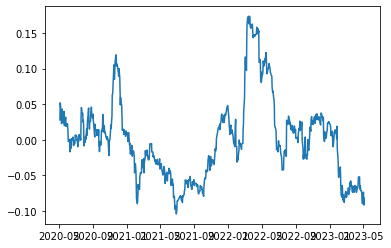

In [5]:
spread = logprice2 - beta * logprice1 - alpha
plt.plot(common_dates, spread)

## Prepare training / test data

In [6]:
scaler = MinMaxScaler(feature_range=(0,1))

def normalize_spread(data, scaler):
    scaled_data = scaler.fit_transform(data.reshape(-1,1))
    return scaled_data


def train_test_split(dates, data, test_ratio=0.1, window_size=30):
    assert len(dates) == len(data)
    test_size = int(len(dates) * test_ratio)
    train_size = len(dates) - test_size
    X_train, y_train, X_test, y_test = [], [], [], []
    for i in range(window_size, train_size):
        X_train.append(data[i - window_size:i])
        y_train.append(data[i])
    for i in range(train_size, train_size + test_size):
        X_test.append(data[i - window_size:i])
        y_test.append(data[i])
    print(f"Finishing splitting, training size: {len(X_train)}, testing size: {len(X_test)}")
    
    return X_train, y_train, X_test, y_test, dates[:train_size], dates[train_size:]

def to_dataloader(X_train, y_train, X_test, y_test, batch_size):
    train_set = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
    train_loader = DataLoader(train_set, batch_size=batch_size)
    test_set = TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test))
    test_loader = DataLoader(test_set, batch_size=batch_size)
    return train_loader, test_loader

scaled_spread = normalize_spread(spread, scaler)
X_train, y_train, X_test, y_test, train_dates, test_dates = train_test_split(common_dates, scaled_spread)
train_loader, test_loader = to_dataloader(X_train, y_train, X_test, y_test, batch_size=8)

Finishing splitting, training size: 650, testing size: 75


## LSTM Model

In [7]:
# Define the LSTM model
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out


# Define the training function
def train(model, train_loader, num_epochs, learning_rate):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    model.train()
    for epoch in range(num_epochs):
        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            if (i+1) % 40 == 0:
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                      .format(epoch+1, num_epochs, i+1, len(train_loader), loss.item()))

# Train the model
input_dim = 1
hidden_dim = 10
output_dim = 1
num_layers = 2
learning_rate = 0.001
num_epochs = 30
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LSTM(input_dim, hidden_dim, output_dim, num_layers).to(device)
train(model, train_loader, num_epochs, learning_rate)

Epoch [1/30], Step [40/82], Loss: 0.0252
Epoch [1/30], Step [80/82], Loss: 0.0045
Epoch [2/30], Step [40/82], Loss: 0.0564
Epoch [2/30], Step [80/82], Loss: 0.0022
Epoch [3/30], Step [40/82], Loss: 0.0595
Epoch [3/30], Step [80/82], Loss: 0.0018
Epoch [4/30], Step [40/82], Loss: 0.0595
Epoch [4/30], Step [80/82], Loss: 0.0013
Epoch [5/30], Step [40/82], Loss: 0.0553
Epoch [5/30], Step [80/82], Loss: 0.0005
Epoch [6/30], Step [40/82], Loss: 0.0407
Epoch [6/30], Step [80/82], Loss: 0.0006
Epoch [7/30], Step [40/82], Loss: 0.0218
Epoch [7/30], Step [80/82], Loss: 0.0017
Epoch [8/30], Step [40/82], Loss: 0.0121
Epoch [8/30], Step [80/82], Loss: 0.0032
Epoch [9/30], Step [40/82], Loss: 0.0059
Epoch [9/30], Step [80/82], Loss: 0.0038
Epoch [10/30], Step [40/82], Loss: 0.0025
Epoch [10/30], Step [80/82], Loss: 0.0049
Epoch [11/30], Step [40/82], Loss: 0.0017
Epoch [11/30], Step [80/82], Loss: 0.0045
Epoch [12/30], Step [40/82], Loss: 0.0012
Epoch [12/30], Step [80/82], Loss: 0.0039
Epoch [13/

Total MSE loss: 7.680168346269056e-05


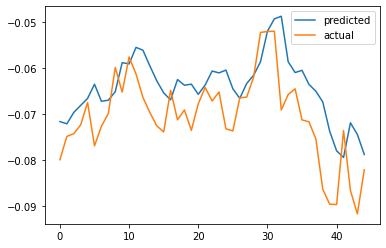

In [100]:
def test(model, test_loader):
    predictions = []
    batch_labels = []
    model.eval()
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            predictions.append(outputs.cpu().numpy())
            batch_labels.append(labels.numpy())
    return predictions, batch_labels

predictions, labels = test(model, test_loader)
predictions = scaler.inverse_transform(np.concatenate(predictions)).flatten()
labels = scaler.inverse_transform(np.concatenate(labels)).flatten()
# # # Visualize the results

plt.plot(predictions, label='predicted')
plt.plot(labels, label='actual')
print(f'Total MSE loss: {mean_squared_error(predictions, labels)}')
plt.legend()
plt.show()

## Trading Model